### some features of a voice signal
* F0
* STFT
* MFCC

In [591]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as ans

### function for computing f0 features

In [592]:
from scipy import stats
def get_f0_stats(x, sr): # need to use native sample rate
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, sr=sr,fmin=50, fmax=1000, fill_na=None)
    if np.any(f0[voiced_flag]) == False:
        return [np.nan,np.nan,np.nan,np.nan]
    else:
        dr = stats.describe(f0[voiced_flag],nan_policy='propagate')._asdict()
        return [dr['mean'], dr['variance'], dr['skewness'], dr['kurtosis']]

In [593]:
voice_clip_meta_data = pd.read_csv("voice_clips_meta_data.csv")
voice_clip_meta_data.head(3)

,client_id,path,sentence,up_votes,down_votes,age,gender
0,538b6b4edc829fd43b014c5d741b9d26330a856d38b6cf...,common_voice_en_32640902.mp3,He has received two state nominations also.,2.0,0.0,seventies,male
1,538b6b4edc829fd43b014c5d741b9d26330a856d38b6cf...,common_voice_en_32640905.mp3,He played cricket for Merchiston Castle School.,2.0,0.0,seventies,male
2,538b6b4edc829fd43b014c5d741b9d26330a856d38b6cf...,common_voice_en_32640907.mp3,Her birth name is not recorded.,2.0,0.0,seventies,male


* all the clips are "loadable" by librosa
* check sample rates of the clips

* get the clip length in second

### handling sample rate
* at first, I thought we could resample to librosa's default sample rate, 22050
* looking at the result of native sampling rates in the above, it may seem to be safe to resample clips into 22050 throughout our project, as librosa doc commented that 22050 is sufficient for music
* still, we do not know if they are sufficient for our purpose, but doing this can avoid sample rate mismatch:
 - when we forgot to enter sample rate in librosa functions that need sample rate, librosa uses 22050 as default, the mismatch of sample rate in computation could potentially generate wrong results without us being aware

#### important find 
 * it turns out that sr parameter to pYing (f0) computation is important
 * when librosa load with resample to 22050, and we use 22050 for pYin, it yields higher f0 
 * for the first clip in voice list, mean f0 => 158, with resampled to 22050
 * when librosa load native sample rate of the clips, and feed to native sr to pYin, f0 is lower => 151
 * and the lower f0 is more reasonable for the male seventies by spot checking
 * accidental find: if we load native sample rate, but run pYin with default sr=22050, it will yield a much lower f0 => 106
 * conclusion: we will have to use native sampling rate throughout all calls

#### sample rate could render entire clip being determined as unvoiced
 * clips that gave errors when computing f0, with resample rate to 22050
 * voice_clip_names[130], 'common_voice_en_26324576.mp3' ,  the entire clip is consider unvoiced
 * for this case, we make the function "get_f0_stats" to return nan
 * then: for the same clipe, voice_clip_names[130], 'common_voice_en_26324576.mp3'
 * when we use clip's native sample rate, i.e., do librosa.load(file, sr=None), we will be able to compute f0 
 * therefore
 * conclusion: we will keep using each clip's native sample rate

 * stats.describe(f0[voiced_flag],nan_policy='propagate')._asdict() can not handle empty array, when f0[voiced_clip] is empty
* use np.any(f0[voiced_flag]) to check if the array is empty
* return np.nan when empty

* fill_na = None in f0 computation will result in f0 with interpolated values
* but this could be misleading for unvoiced segments, then need to use voiced_flag to select the true f0 in the result 
* f0, voiced_flag, voiced_probs = librosa.pyin(voice_list[0], fmin=50, fmax=1000, fill_na=None)
* dr = stats.describe(f0[voiced_flag])._asdict()
* pd.DataFrame([dr], columns = dr.keys())

### experiment: impact of sample rate on f0 features

In [550]:
x, sr = librosa.load(data_dir+"common_voice_en_32640902.mp3",sr=None) # native sample rate
print(sr, get_f0_stats(x,sr)) # matching sample rate
x, sr = librosa.load(data_dir+"common_voice_en_32640902.mp3") # resampled to 22050
print(sr, get_f0_stats(x,sr)) # default 22050
x, sr = librosa.load(data_dir+"common_voice_en_32640902.mp3",sr=None) #native sample rate
print(sr, get_f0_stats(x,sr=22050)) # mismatch sample rate, the clip has sample rate 32000


32000 [151.555209997355, 1932.1780875199618, 4.816045850841268, 42.30846148582021]
22050 [158.8519937408142, 4011.515810296571, 5.68394001214613, 45.59973262677548]
32000 [106.66213191643054, 674.5507915310535, 1.499848060363915, 4.334394867664586]


In [552]:
x, sr = librosa.load(data_dir+"common_voice_en_26324576.mp3",sr=None)
print(sr, get_f0_stats(x,sr))
x, sr = librosa.load(data_dir+"common_voice_en_26324576.mp3")
print(sr, get_f0_stats(x,sr))
x, sr = librosa.load(data_dir+"common_voice_en_26324576.mp3",sr=None)
print(sr, get_f0_stats(x,sr=22050))

32000 [93.49208242223375, 13.13603398912084, 0.35089497051495044, -1.4437582416366617]
22050 [nan, nan, nan, nan]
32000 [69.16941409692397, 56.50033621222401, 0.38405906081525476, -1.435218045576114]


### compute f0 features for all clips

* some selected audio files in the common voice collection
* audiofile = list_clip.path[100]
* audiofile = "common_voice_en_32810621.mp3" # eighties female
* audiofile = "common_voice_en_30282850.mp3" # fifties female
* audiofile = "common_voice_en_32879293.mp3" # eighties male
* audiofile = "common_voice_en_32260076.mp3" # twenties female
* audiofile = "common_voice_en_20002554.mp3" # sixties male
* audiofile = "common_voice_en_30615145.mp3"  # teen male

* audiofile = "common_voice_en_26324576.mp3" # clips 130 in meta file, returning unvoiced if loaded with sr unspecified, i.e., librosa will resample to 22050, causing f0 computation returning unvoiced at all frames
* audiofile = "common_voice_en_18657273.mp3" # clip 8773, resulting in nan for f0 variance, skewness and kurtosis, but has mean f0

In [597]:
voice_clip_meta_data.iloc[8773]

client_id     a93ace244d1834347c633aec367a5a9ebd3cbb3a51c641...
path                               common_voice_en_18657273.mp3
sentence                                  Rest assured of that!
up_votes                                                    2.0
down_votes                                                  0.0
age                                                    twenties
gender                                                     male
x             [0.0, -1.2087423e-13, -4.1241912e-14, -1.84468...
sr                                                        48000
Name: 8773, dtype: object

In [598]:
x, sr = librosa.load(data_dir+"common_voice_en_18657273.mp3",sr=None)
print(sr, get_f0_stats(x,sr))

48000 [187.68759933422865, nan, nan, nan]


/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_77939/3322483979.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  dr = stats.describe(f0[voiced_flag],nan_policy='propagate')._asdict()
/Users/yingli/opt/anaconda3/envs/voice1/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/yingli/opt/anaconda3/envs/voice1/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/yingli/opt/anaconda3/envs/voice1/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1522: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are 

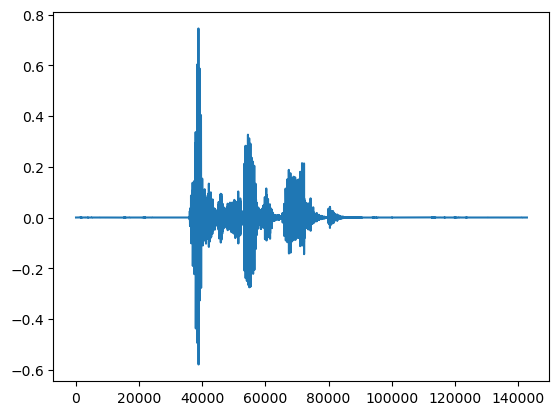

In [599]:
plt.plot(x)

### STFT

In [600]:
data_dir = '/Users/yingli/Development/AppliedDataScience/voice_clips/'
#audiofile = "common_voice_en_35117939.mp3" # teen female
audiofile = "common_voice_en_26324576.mp3"
x, sr = librosa.load(data_dir+audiofile, sr = None)
x.shape, sr

((131328,), 32000)

In [602]:
x_stft = librosa.stft(x)
x_stft.shape

(1025, 257)

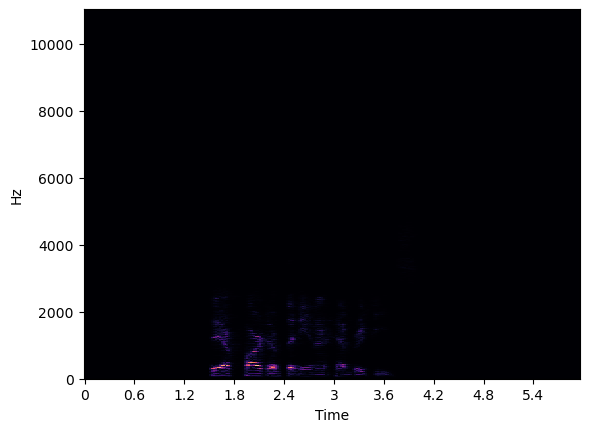

In [603]:
librosa.display.specshow(np.abs(x_stft),x_axis='time',y_axis='hz')

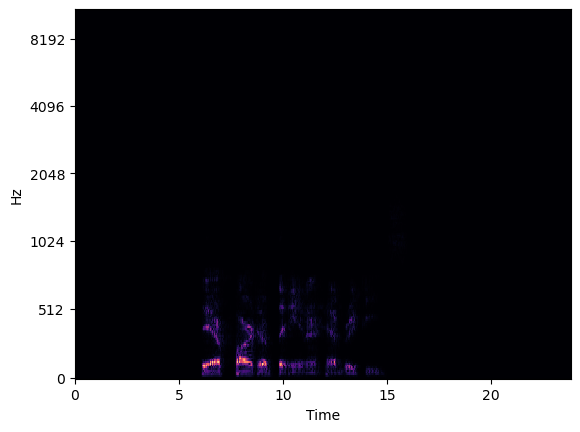

In [487]:
librosa.display.specshow(np.abs(x_stft),x_axis='time',y_axis='mel')

In [611]:
x_stft_mag, x_stft_ph = librosa.magphase(x_stft)

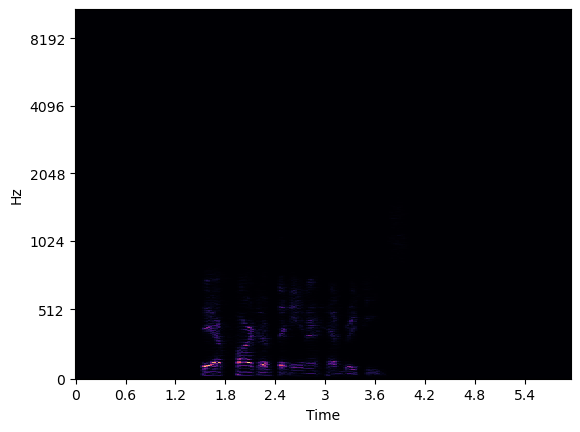

In [612]:
librosa.display.specshow(x_stft_mag, x_axis='time',y_axis='mel')

In [613]:
np.array_equal(x_stft_mag, np.abs(x_stft))

True

* librosa.feature.melspectrogram can take a spectrogram as input, S =, and it will turn into mel scale
* it can also take a signal as input, y = , and it will compute magnitude spectrogram and convert to mel scale

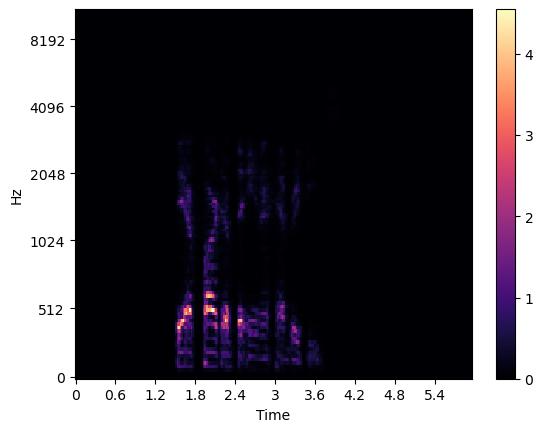

In [614]:
x_stft_mag_mel = librosa.feature.melspectrogram(S=x_stft_mag, sr=sr)
librosa.display.specshow(x_stft_mag_mel, x_axis='time', y_axis='mel')
plt.colorbar()

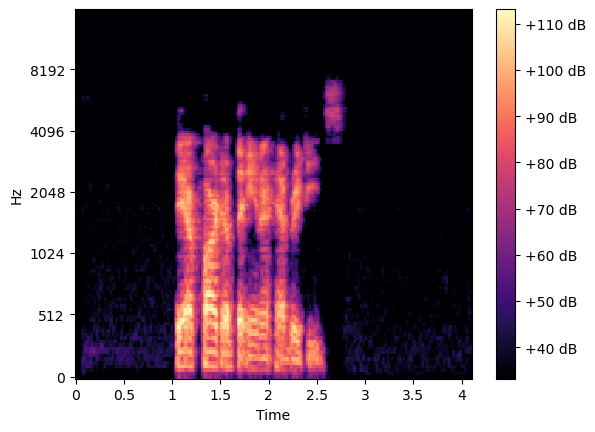

In [615]:
x_stft_mag_mel_db = librosa.amplitude_to_db(x_stft_mag_mel, ref=np.min)
librosa.display.specshow(x_stft_mag_mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [616]:
x_stft = librosa.stft(x)
x_stft_log = librosa.amplitude_to_db(x_stft, ref=np.max)
x_stft_log_istft = librosa.istft(x_stft_log)


/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_77939/3289777025.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  x_stft_log = librosa.amplitude_to_db(x_stft, ref=np.max)


In [617]:
x_stft.shape, x_stft_log.shape, x_stft_log_istft.shape, x.shape

((1025, 257), (1025, 257), (131072,), (131328,))

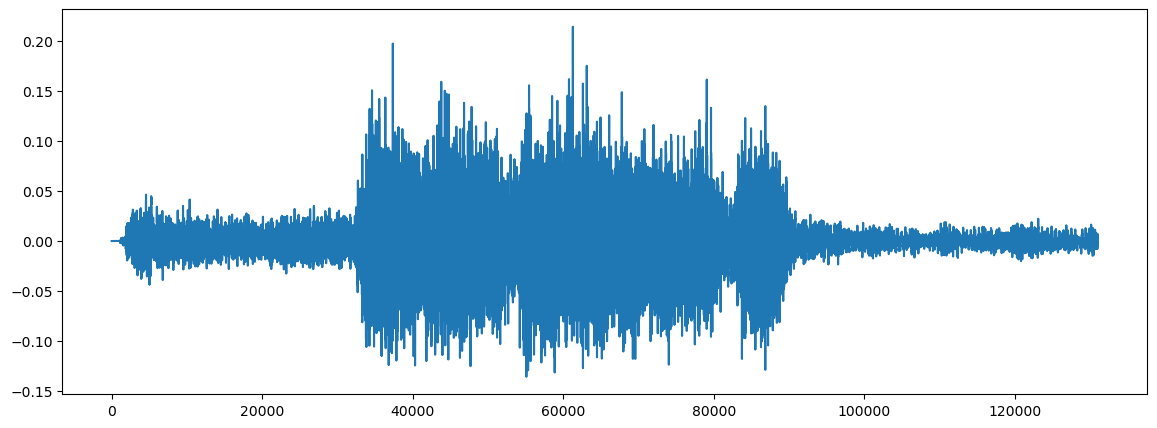

In [618]:
plt.figure(figsize=(14, 5))
plt.plot(x_stft_log_istft)

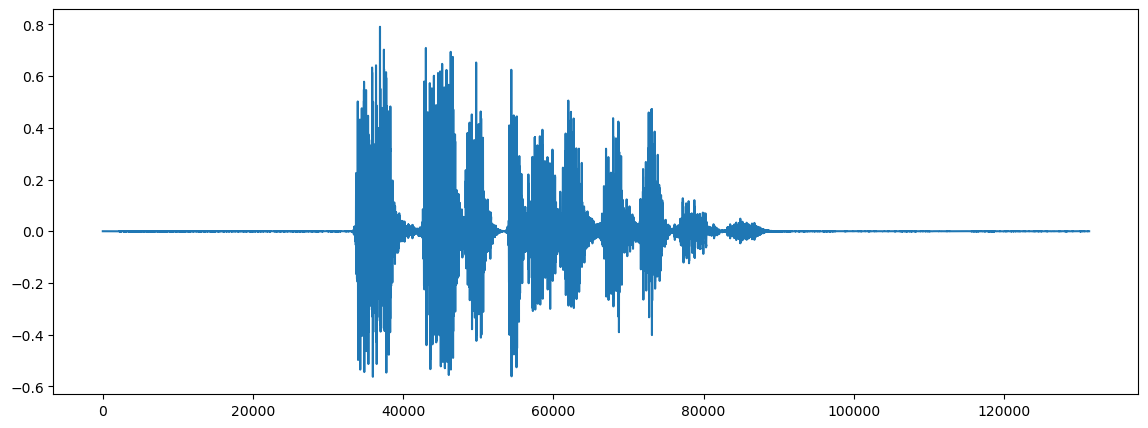

In [619]:
plt.figure(figsize=(14, 5))
plt.plot(x)

In [ ]:
### MFCC 

In [630]:
S = librosa.feature.melspectrogram(y=x, sr=sr,n_mels = 128,fmax=8000)

In [654]:
x_mfcc = librosa.feature.mfcc(y=x,sr=sr,n_mfcc=40,n_mels = 128, dct_type=2)
x_mfcc.shape

(40, 257)

In [655]:
S_mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S),sr=sr,n_mfcc=40, n_mels = 128,dct_type=2)
S_mfcc.shape

(40, 257)

In [656]:
np.array_equal(x_mfcc, S_mfcc)

False

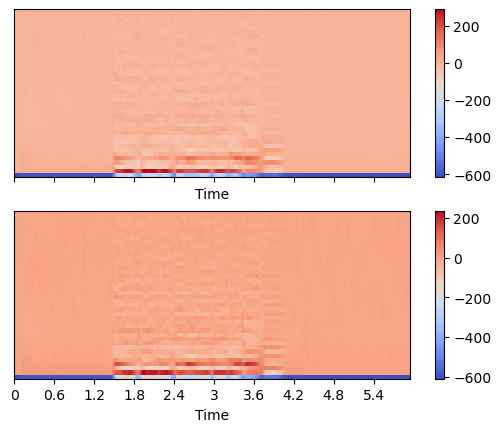

In [657]:
fig, ax = plt.subplots(nrows=2, sharex=True,sharey=True)
img1 = librosa.display.specshow(x_mfcc, x_axis='time', ax=ax[0])
fig.colorbar(img1, ax = [ax[0]])
img2 = librosa.display.specshow(S_mfcc, x_axis='time', ax=ax[1])
fig.colorbar(img2, ax = [ax[1]])

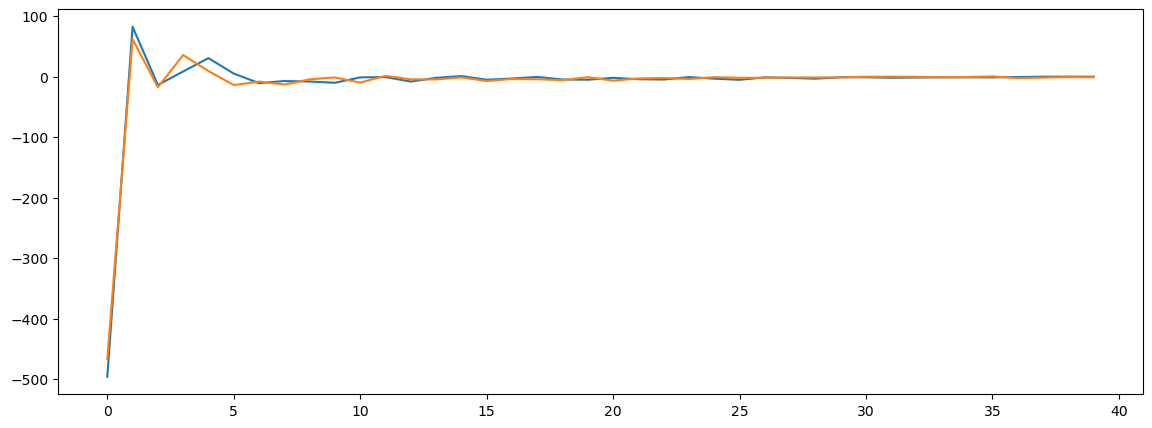

In [658]:
x_mfcc_mean = x_mfcc.mean(axis=1)
S_mfcc_mean = S_mfcc.mean(axis=1)

plt.figure(figsize=(14, 5))
plt.plot(x_mfcc_mean)
plt.plot(S_mfcc_mean)

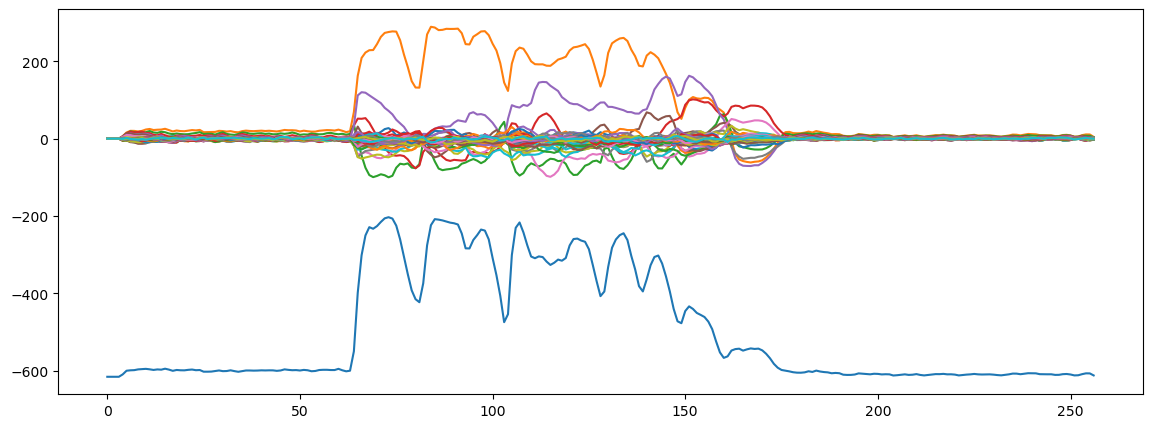

In [659]:
plt.figure(figsize=(14, 5))
plt.plot(x_mfcc.T)

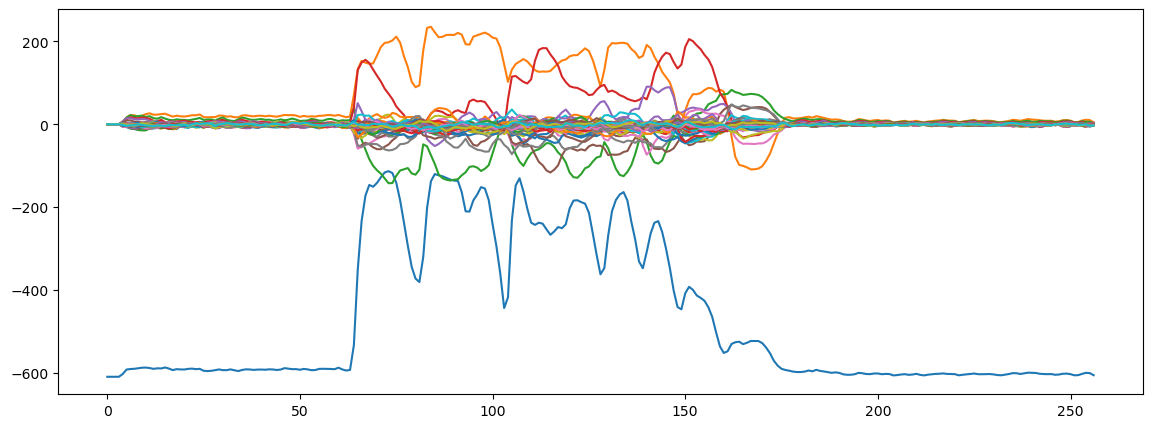

In [660]:
plt.figure(figsize=(14, 5))
plt.plot(S_mfcc.T)

* use np.unravel_index(a.argmax(), a.shape) to fidn the index of argmax

In [82]:
np.unravel_index(x.argmax(), x.shape)

(14165,)

In [83]:
14165 /512

27.666015625

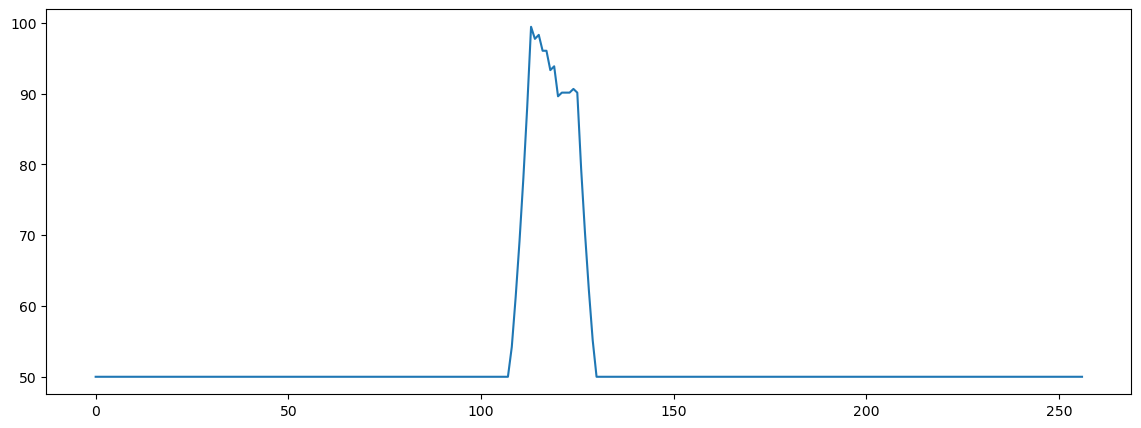

In [661]:
plt.figure(figsize=(14, 5))
f0, voiced_flag, voiced_probs = librosa.pyin(x,sr=sr, fmin=50, fmax=1000, fill_na=None)
plt.plot(f0)

In [662]:
f0.shape, f0[voiced_flag].shape

((257,), (13,))

In [663]:
f0[voiced_flag].mean()

93.49208242223375

In [664]:
my_voice = "/Users/yingli/Development/AppliedDataScience/John_1_1_YingLi.wav" # Ying's voice
y, y_sr = librosa.load(my_voice, sr=None, mono=False)
y_f0, y_voiced_flag, y_voiced_probs = librosa.pyin(y,sr=y_sr, fmin=50, fmax=1000, fill_na=None)

In [665]:
y_f0[y_voiced_flag].mean()

212.99189907774112

In [666]:
from scipy import stats
stats.describe(y_f0[0,][y_voiced_flag[0,]]),stats.describe(y_f0[1,][y_voiced_flag[1,]])

(DescribeResult(nobs=313, minmax=(149.83070768766817, 404.647776120769), mean=212.99189907774112, variance=1022.3246451065739, skewness=1.5555286081352635, kurtosis=4.766870815497433),
 DescribeResult(nobs=313, minmax=(149.83070768766817, 404.647776120769), mean=212.99189907774112, variance=1022.3246451065739, skewness=1.5555286081352635, kurtosis=4.766870815497433))

In [667]:
fft = np.fft.fft(x[:2048])
ifft = np.fft.ifft(fft)

In [668]:
print(pd.Series(librosa.fft_frequencies(sr=sr, n_fft=2048)).sort_values())
sr/2048

0           0.000
1          15.625
2          31.250
3          46.875
4          62.500
          ...    
1020    15937.500
1021    15953.125
1022    15968.750
1023    15984.375
1024    16000.000
Length: 1025, dtype: float64


15.625

/Users/yingli/opt/anaconda3/envs/voice1/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


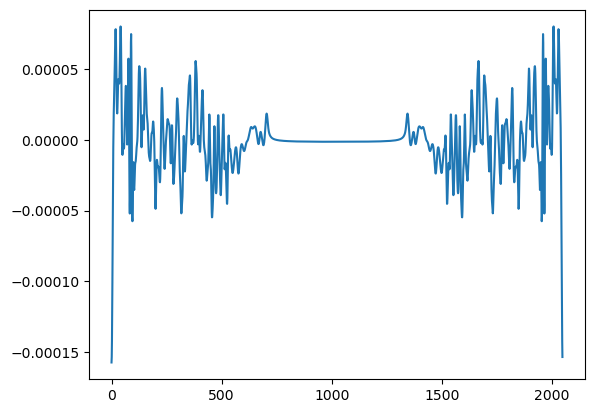

In [669]:
plt.plot(fft)

In [670]:
librosa.frames_to_samples([27])

array([13824])

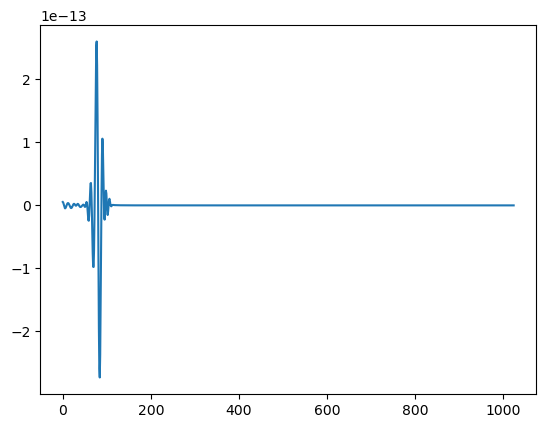

In [671]:
F = librosa.stft(x)
plt.plot(F[:,0])

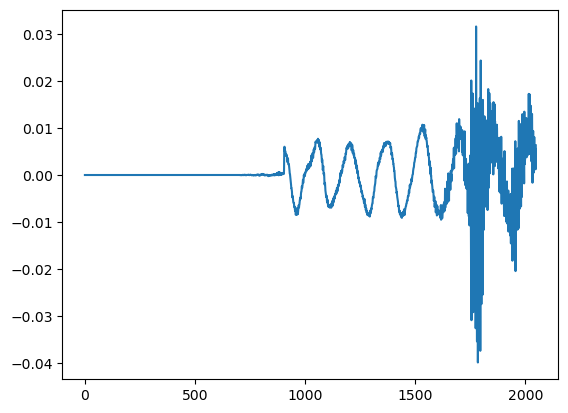

In [108]:
plt.plot(x[0:2048])

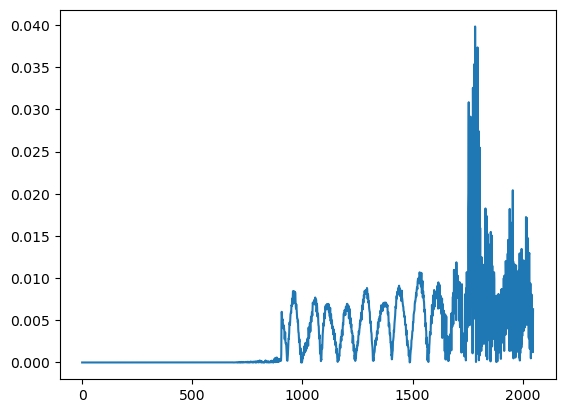

In [107]:
plt.plot(np.abs(ifft))

### STFT

In [22]:
D = librosa.stft(y=x)
print(x.shape, sr, D.shape)
D.shape[0] == 1 + 2048/2, D.shape[1] * (2048/4),  x.shape[0]

(143678,) 22050 (1025, 281)


(True, 143872.0, 143678)

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(librosa.amplitude_to_db(np.abs(D[27])))

In [7]:
type(D[0,0])

numpy.complex64

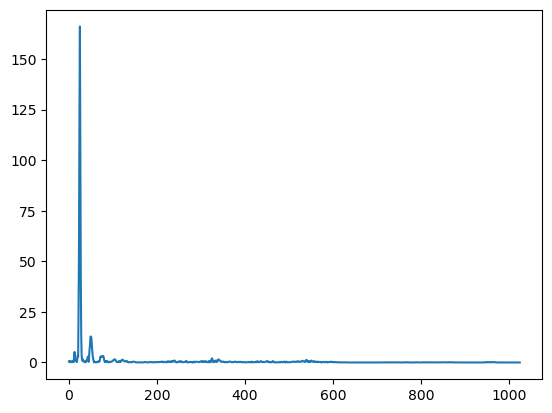

In [93]:
a =np.abs(D)
np.unravel_index(a.argmax(), a.shape)
plt.plot(np.abs(D[:,27]))

In [96]:
512*27

13824

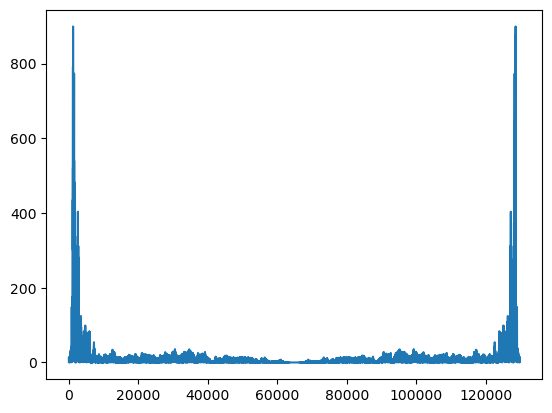

In [97]:
plt.plot(abs(np.fft.fft(x[13824:148486])))

In [52]:
np.fft.fft(np.array([2,4,-1,6]))


array([11.+0.j,  3.+2.j, -9.+0.j,  3.-2.j])

In [46]:
librosa.get_fftlib()

<module 'numpy.fft' from '/Users/yingli/opt/anaconda3/envs/voice1/lib/python3.10/site-packages/numpy/fft/__init__.py'>

In [45]:
m = librosa.filters.mel(y=x, sr=sr, n_fft=1024, n_mels=128, fmin=0.0, fmax=None, htk=False, norm='slaney')
m.shape

TypeError: mel() got an unexpected keyword argument 'y'

In [10]:
f0.shape, voiced_flag.shape, voiced_probs.shape, x.shape[0]/f0.shape[0]

((408,), (408,), (408,), 511.05882352941177)

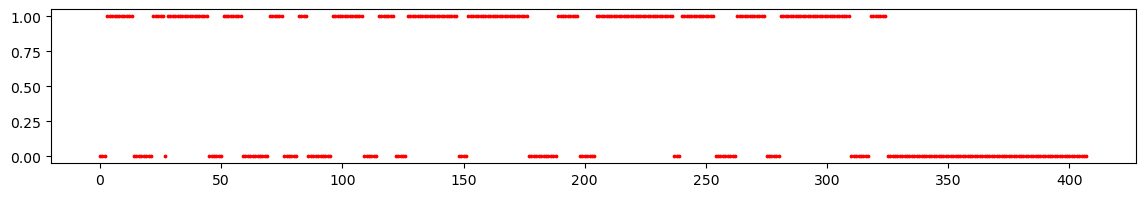

In [11]:
plt.figure(figsize=(14, 2))
plt.scatter(range(voiced_flag.shape[0]),voiced_flag*1, s=3,color = "r")

In [12]:
voiced_flag[50:60], f0[50:60]

(array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        False]),
 array([256.38881638, 250.53288772, 233.75544971, 227.10088581,
        221.91389441, 219.36499594, 220.63576443, 225.79288096,
        228.41646786, 228.41646786]))

### compute mel-spectrom

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

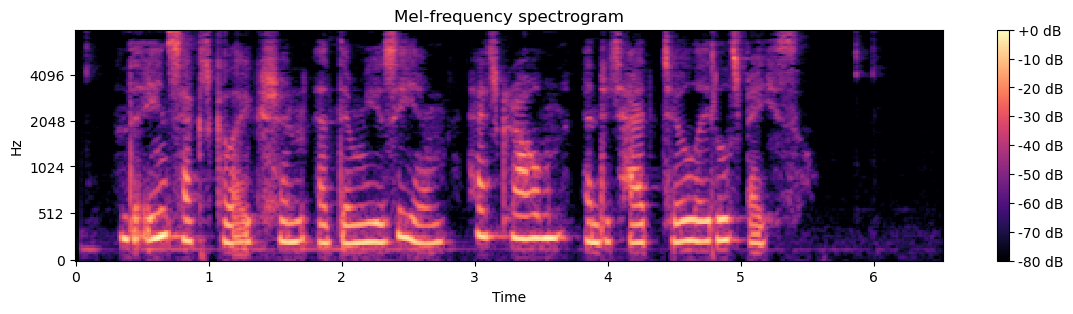

In [13]:
fig, ax = plt.subplots(figsize=(14, 3))

S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [14]:
# sampling rate for 125 microsecond sampling gap 
# number of smaple for signal of 32 miliseconds length
1/0.000125, 32/0.125

(8000.0, 256.0)

In [15]:
M = librosa.feature.melspectrogram(y=x, sr=sr, n_mels = 128)
M.shape

(128, 408)

In [16]:
D = np.abs(librosa.stft(x))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

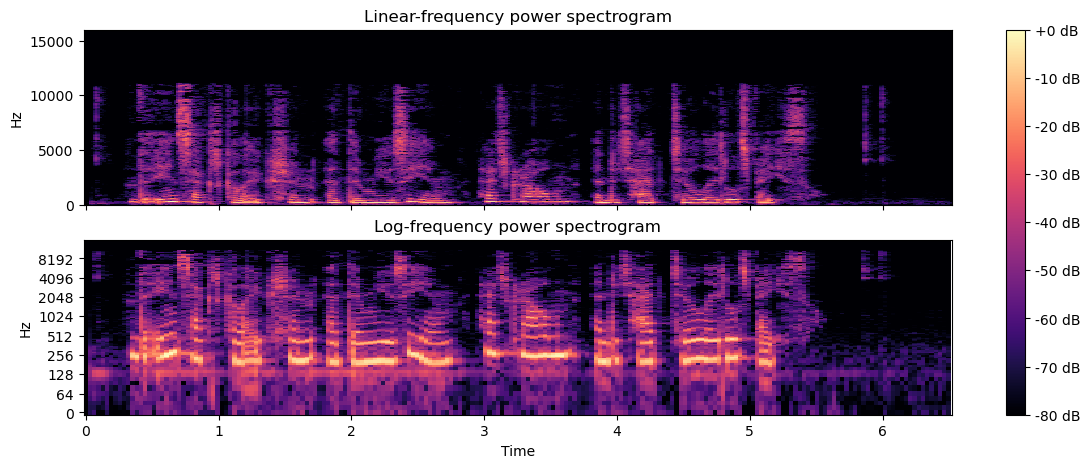

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (14,5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(x, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time', 
                         sr=sr, hop_length=hop_length, ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [18]:
tempo, beat_frames = librosa.beat.beat_track(y=x, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

Estimated tempo: 98.68 beats per minute


In [19]:
# 4. Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_times

array([0.432, 0.96 , 1.456, 2.016, 2.624, 3.248, 3.856, 4.448])

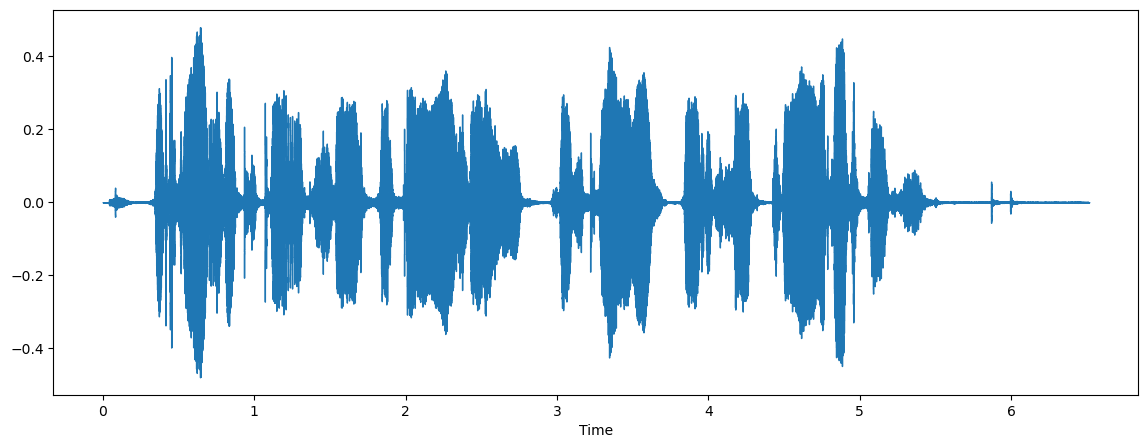

In [20]:
audiofile = "common_voice_en_35117939.mp3" # teen female
x, sr = librosa.load(data_dir+audiofile)
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

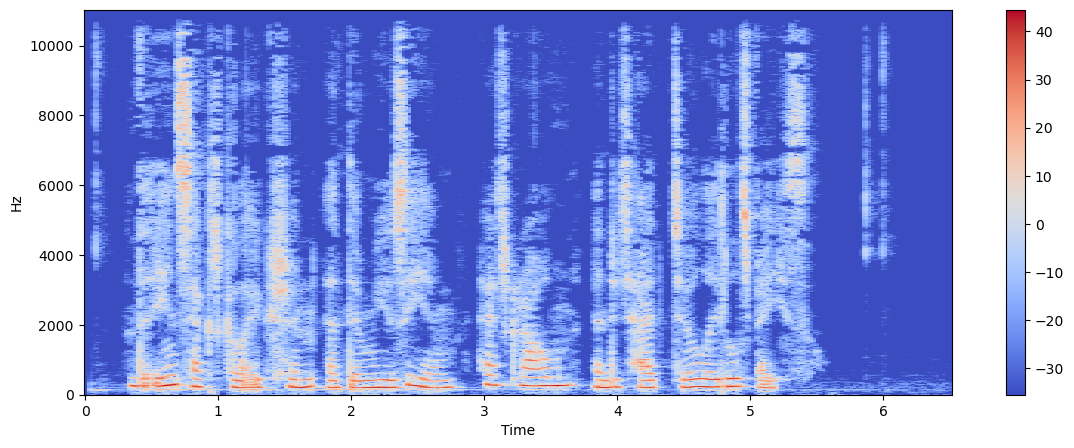

In [21]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

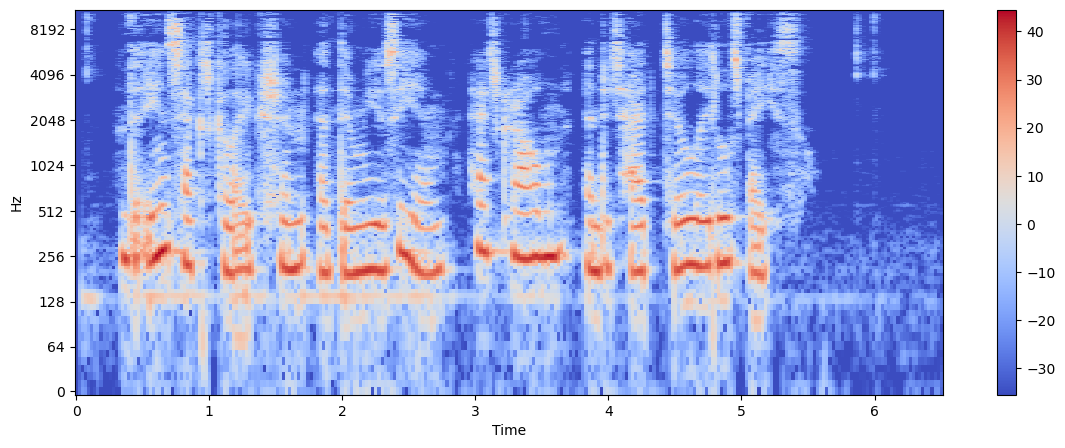

In [22]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [23]:
mfcc = librosa.feature.mfcc(y=x, sr=sr)
mfcc.shape

(20, 281)

<Axes: >

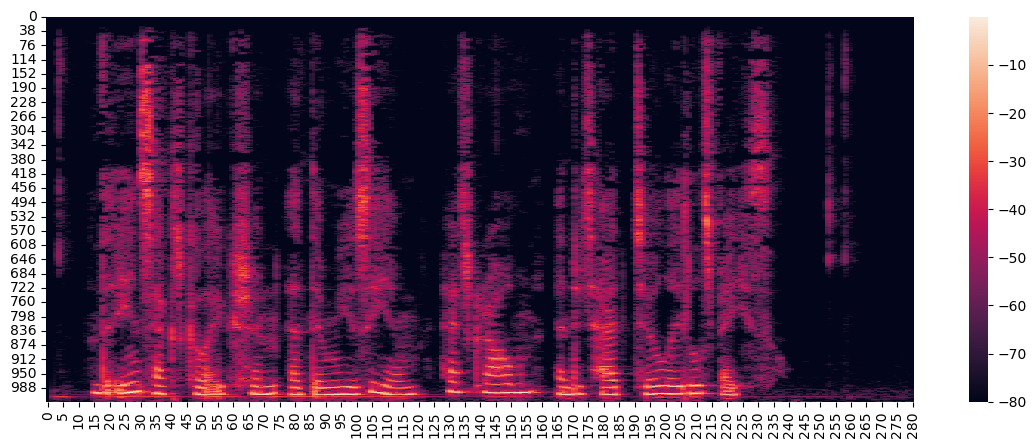

In [24]:
import seaborn as sns
plt.figure(figsize=(14, 5))
fft = librosa.stft(y=x)
sns.heatmap(np.flip(librosa.amplitude_to_db(abs(fft),ref=np.max), axis =0))

/var/folders/kf/38b2x8pj2x50xtns4nqt6ysw0000gn/T/ipykernel_74722/1179812508.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  img = librosa.display.specshow(librosa.amplitude_to_db(fft,


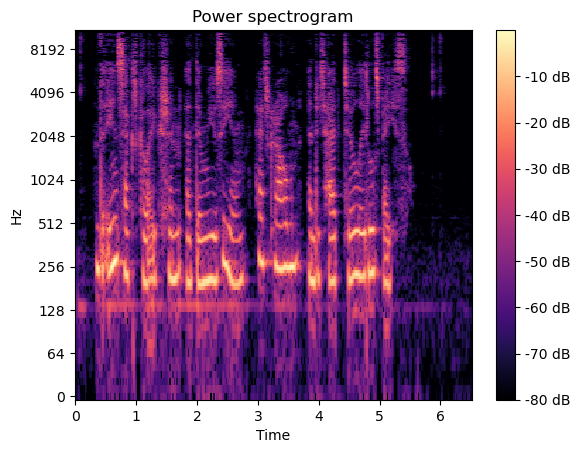

In [25]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(fft,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")